# Kaon Decay Spectra

## Setup

In [3]:
from typing import Callable, List, Tuple
from enum import Enum
import os
from pathlib import Path

import numpy as np
import numpy.typing as npt
from scipy import integrate

import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler

import h5py

from hazma.rambo import generate_phase_space
from hazma.parameters import alpha_em
from hazma.decay import charged_pion as dnde_cp
from hazma.decay import neutral_pion as dnde_np
from hazma.decay import muon as dnde_mu

In [4]:
MPI = 139.57039  # m[pi+] = 139.57039 ± 0.00018
MK = 493.677  # m[K+] = 493.677 ± 0.016
MPI0 = 134.9768  # m[pi0] = 134.9768 ± 0.0005
ME = 0.5109989461  # m[e-] = 0.5109989461 ± 3.1e-09
MMU = 105.6583745  # m[mu-] = 105.6583745 ± 2.4e-06

qualitative = [
    "#e41a1c",
    "#377eb8",
    "#4daf4a",
    "#984ea3",
    "#ff7f00",
    "#a65628",
    "#f781bf",
    "#999999",
    "#ffff33",
]

mpl.rcParams["text.usetex"] = True
mpl.rcParams["text.latex.preamble"] = " ".join(
    [r"\usepackage{physics}", r"\usepackage{bm}", r"\usepackage{amsmath}"]
)
mpl.rcParams["axes.prop_cycle"] = cycler(color=qualitative)

In [5]:
# BR(K -> μ+, νμ) = (63.56 ± 0.11) %
BR_K_TO_MU_NUMU = 63.56e-2
# BR(K -> π+, π0) = (20.67 ± 0.08 ) %
BR_K_TO_PI_PI0 = 20.67e-2
# BR(K -> π+, π+, π−) = (5.583 ± 0.024) %
BR_K_TO_PI_PI_PI = 5.583e-2
# BR(K -> π0, e+, νe) = (5.07 ± 0.04) %
BR_K_TO_E_NUE_PI0 = 5.07e-2
# BR(K -> π0, μ+, νμ)   (3.352 ± 0.033) %
BR_K_TO_MU_NUMU_PI0 = 3.352e-2
# BR(K -> π+, π0, π0) = (1.760 ± 0.023) %
BR_K_TO_PI_PI0_PI0 = 1.760e-2

# BR(K -> e+, νe) = (1.582 ± 0.007)×10−5
BR_K_TO_E_NUE = 1.582e-5
# BR(K -> π0, π0, e+, νe) = (2.55 ± 0.04)×10−5
BR_K_TO_E_NUE_PI0_PI0 = 2.55e-5
# BR(K -> π+, π−, e+, νe) =  (4.247 ± 0.024)×10−5
BR_K_TO_E_NUE_PI_PI = 4.247e-5
# from Pythia8306 (can't find in PDG)
BR_K_TO_MU_NUMU_PI0_PI0 = 0.0000140
# BR(K -> π+, π−, μ+, νμ) =  (1.4 ± 0.9)×10−5
BR_K_TO_MU_NUMU_PI_PI = 1.4e-5
# BR(K -> e+, νe, e+, e−) =  (2.48 ± 0.20 )×10−8
BR_K_TO_E_E_E_NUE = 2.48e-8
# BR(K -> μ+, νμ, e+, e−) =  (7.06 ± 0.31 )×10−8
BR_K_TO_MU_E_E_NUMU = 7.06e-8
# BR(K -> e+, νe, μ+, μ−) =  (1.7 ± 0.5  )×10−8
BR_K_TO_MU_MU_E_NUE = 1.7e-8
# BR(K -> π+, e+, e−) = (3.00 ± 0.09 )×10−7
BR_K_TO_PI_E_E = 3.00e-7
# BR(K -> π+, μ+, μ−) = (9.4 ± 0.6  )×10−8
BR_K_TO_PI_MU_MU = 9.4e-8

## Final State Energy Distributions

In [4]:
class ThreeBodyPhaseSpace:
    def __init__(
        self, m0: float, m1: float, m2: float, m3: float, msqrd: Callable
    ) -> None:
        self.m0 = m0
        self.m1 = m1
        self.m2 = m2
        self.m3 = m3
        self.msqrd = msqrd

    def __energy_bounds(
        self, m0: float, m1: float, m2: float, m3: float
    ) -> Tuple[float, float]:
        emin = m1
        emax = (m0 ** 2 + m1 ** 2 - (m2 + m3) ** 2) / (2 * m0)
        return (emin, emax)

    def _energy_bounds(self) -> List[npt.NDArray]:
        m0 = self.m0
        m1, m2, m3 = self.m1, self.m2, self.m3
        return [
            self.__energy_bounds(m0, m1, m2, m3),
            self.__energy_bounds(m0, m2, m1, m3),
            self.__energy_bounds(m0, m3, m1, m2),
        ]

    def __energy_probabilities(
        self, bins: tuple[npt.NDArray, npt.NDArray, npt.NDArray], npts=10000
    ) -> List[npt.NDArray]:
        space = generate_phase_space(
            [self.m1, self.m2, self.m3], self.m0, num_ps_pts=npts
        )
        p1 = space[:, 0:4]
        p2 = space[:, 4:8]
        p3 = space[:, 8:12]
        weights = space[:, -1]

        e1s = p1[:, 0]
        e2s = p2[:, 0]
        e3s = p3[:, 0]

        s = (p2 + p3) ** 2
        t = (p1 + p3) ** 2

        s[:, 1:] *= -1
        t[:, 1:] *= -1

        s = np.sum(s, axis=1)
        t = np.sum(t, axis=1)

        weights = weights * self.msqrd(s, t)

        p1s, _ = np.histogram(e1s, bins=bins[0], weights=weights, density=True)
        p2s, _ = np.histogram(e2s, bins=bins[1], weights=weights, density=True)
        p3s, _ = np.histogram(e3s, bins=bins[2], weights=weights, density=True)

        return np.array([p1s, p2s, p3s])

    def __invariant_mass_probabilities(
        self, i: int, j: int, bins: npt.NDArray, npts: int = 10000
    ) -> npt.NDArray:
        space = generate_phase_space(
            [self.m1, self.m2, self.m3], self.m0, num_ps_pts=npts
        )
        ps = (space[:, 0:4], space[:, 4:8], space[:, 8:12])
        weights = space[:, -1]

        sij = (ps[i] + ps[j]) ** 2
        s = (ps[1] + ps[2]) ** 2
        t = (ps[0] + ps[2]) ** 2

        s[:, 1:] *= -1
        t[:, 1:] *= -1
        sij[:, 1:] *= -1

        s = np.sum(s, axis=1)
        t = np.sum(t, axis=1)
        sij = np.sum(sij, axis=1)

        weights = weights * self.msqrd(s, t)

        probs = np.histogram(sij, bins=bins, weights=weights, density=True)[0]

        return probs

    def __update_distribution(
        self, dist: npt.NDArray, ctor: Callable[[], npt.NDArray], batchsize: int
    ) -> Tuple[npt.NDArray, float]:
        new_dist: npt.NDArray = np.zeros_like(dist)
        for _ in range(batchsize):
            new_dist += ctor()
        max_delta = np.max(np.abs(new_dist / dist))  # type: ignore

        return new_dist + dist, max_delta

    def __build_distribution(
        self,
        dist: npt.NDArray,
        ctor: Callable,
        eps: float,
        maxiter: int,
        batchsize: int,
    ) -> npt.NDArray:
        # warm up
        for _ in range(batchsize):
            dist += ctor()
        count = batchsize

        max_delta = np.inf
        converged = False
        for _ in range(maxiter):
            dist, max_delta = self.__update_distribution(dist, ctor, batchsize)
            count += batchsize

            if max_delta < eps:
                converged = True
                break

        if not converged:
            print(
                f"warning: popability distributions did not converge. max error: {max_delta}"
            )
        return dist / count

    def energy_distributions(
        self, nbins: int = 20, eps: float = 1e-2, maxiter: int = 100, batchsize: int = 5
    ) -> List[Tuple[npt.NDArray, npt.NDArray]]:
        ebounds = self._energy_bounds()
        bins = (
            np.linspace(ebounds[0][0], ebounds[0][1], nbins + 1),
            np.linspace(ebounds[1][0], ebounds[1][1], nbins + 1),
            np.linspace(ebounds[2][0], ebounds[2][1], nbins + 1),
        )
        cs = (
            (bins[0][1:] + bins[0][:-1]) / 2,
            (bins[1][1:] + bins[1][:-1]) / 2,
            (bins[2][1:] + bins[2][:-1]) / 2,
        )

        ps = np.zeros((3, nbins), dtype=np.float64)  # type: ignore
        ctor = lambda: self.__energy_probabilities(bins)
        ps = self.__build_distribution(ps, ctor, eps, maxiter, batchsize)

        return [(c, p) for c, p in zip(cs, ps)]

    def invariant_mass_distribution(
        self, i: int, j: int, nbins: int = 20, eps=1e-2, maxiter=100, batchsize=5
    ) -> Tuple[npt.NDArray, npt.NDArray]:
        ms = [self.m1, self.m2, self.m3]
        # s = (pi + pj)^2 = (P - pk)^2
        k = {0, 1, 2}.difference({i, j}).pop()
        smin = (ms[i] + ms[j]) ** 2
        smax = (self.m0 - ms[k]) ** 2
        bins: npt.NDArray = np.linspace(smin, smax, nbins + 1)
        cs = (bins[1:] + bins[:-1]) / 2

        ps = np.zeros(nbins, dtype=np.float64)  # type: ignore
        ctor = lambda: self.__invariant_mass_probabilities(i, j, nbins)
        ps = self.__build_distribution(ps, ctor, eps, maxiter, batchsize)

        return (cs, ps)

### $K^{\pm} \to \pi^{\pm} + \pi^{\pm} + \pi^{\mp}$

The matrix element for $K^{\pm} \to \pi^{\pm} + \pi^{\pm} + \pi^{\mp}$ come from the weak Chiral lagrangian:
\begin{align*}
    \mathcal{L} \supset \mathrm{Tr}\left(\lambda_{6}
    \left(\partial_{\mu}U\right)^{\dagger}\left(\partial_{\mu}U\right)
    \right)
\end{align*}
The amplitude is:
\begin{align*}
    \mathcal{A} &\propto 
                \left(P\cdot p_{1}\right)
    +           \left(P\cdot p_{2}\right)
    -\frac{2}{3}\left(P\cdot p_{3} + p_{1}\cdot p_{2}\right)
    -\frac{1}{3}\left(p_{1}\cdot p_{3} + p_{2}\cdot p_{3}\right)\\
    &= \frac{2}{3}\left(m_{K}^{2}+3 m_{\pi}^{2} - s - t\right)
\end{align*}
where $P$ is the kaon momentum and $p_{1}, p_{2}$ and $p_{3}$ are the pion momenta. The invariants $s,t$ are given by
\begin{align*}
    s &= (P-p_{1})^{2} = (p_{2} + p_{3})^2\\
    t &= (P-p_{2})^{2} = (p_{1} + p_{3})^2
\end{align*}

In [5]:
def msqrd_k_to_pi_pi_pi(s, t):
    return (2.0 / 3.0 * (MK ** 2 + 3 * MPI ** 2 - s - t)) ** 2

In [6]:
k_to_pi_pi_pi_edists = ThreeBodyPhaseSpace(MK, MPI, MPI, MPI, msqrd_k_to_pi_pi_pi).energy_distributions(25, maxiter=1000)
k_to_pi_pi_pi_s_dist = ThreeBodyPhaseSpace(MK, MPI, MPI, MPI, msqrd_k_to_pi_pi_pi).invariant_mass_distribution(1, 2, 25, maxiter=1000)
k_to_pi_pi_pi_t_dist = ThreeBodyPhaseSpace(MK, MPI, MPI, MPI, msqrd_k_to_pi_pi_pi).invariant_mass_distribution(0, 2, 25, maxiter=1000)
k_to_pi_pi_pi_u_dist = ThreeBodyPhaseSpace(MK, MPI, MPI, MPI, msqrd_k_to_pi_pi_pi).invariant_mass_distribution(0, 1, 25, maxiter=1000)

In [7]:
def k_to_pi_pi_pi_s_dist_analytic(s):
    mu = MPI/MK
    x = 1.0 - s / MK**2 + mu**2
    norm = -10317.189053594739
    return np.sqrt((x**2 - 4*mu**2) * (1 - x - 3 * mu**2)/(1-x+mu**2)**3) * ((1-x) * (mu**2 - x * (x + 3 * mu**2)) - 3 * mu**2 * (2+mu**2)) / norm

# integrate.quad(k_to_pi_pi_pi_s_dist_analytic, 4*MPI**2, (MK-MPI)**2)

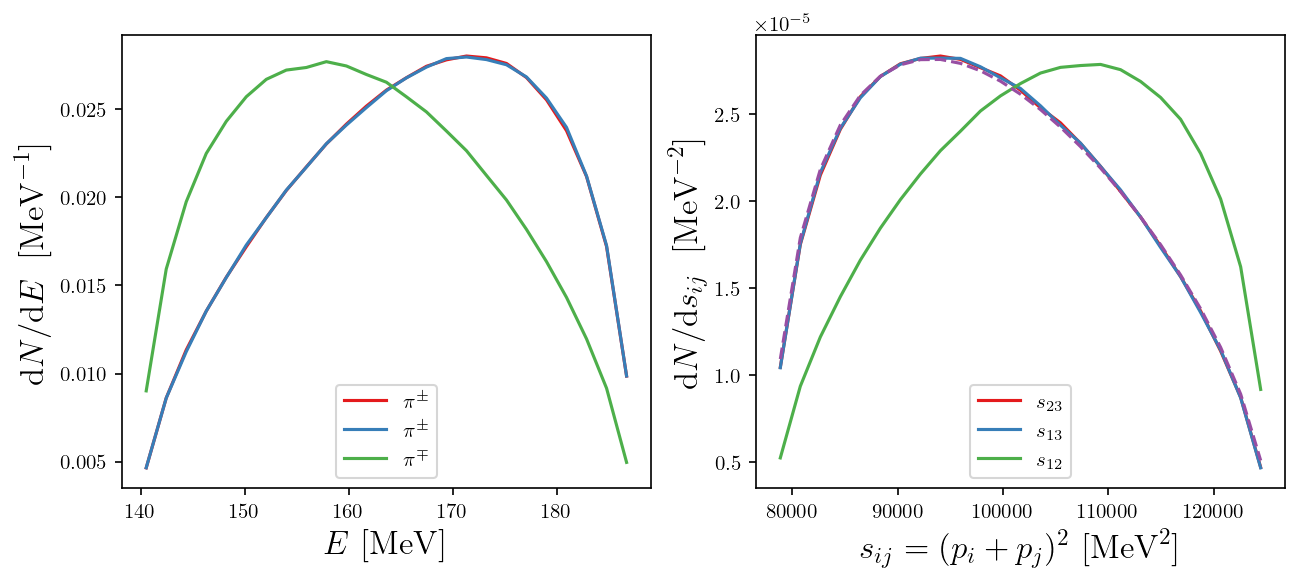

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(10,4))

labels = [r"$\pi^{\pm}$", r"$\pi^{\pm}$", r"$\pi^{\mp}$"]
for (cs, ps), label in zip(k_to_pi_pi_pi_edists, labels):
    axes[0].plot(cs, ps, label=label)



axes[0].legend()
axes[0].set_ylabel(r"$\dv*{N}{E} \ [\mathrm{MeV}^{-1}]$", fontdict={'size': 16})
axes[0].set_xlabel(r"$E \ [\mathrm{MeV}]$", fontdict={'size': 16})

labels = [r"$s_{23}$", r"$s_{13}$", r"$s_{12}$"]
dists = [k_to_pi_pi_pi_s_dist, k_to_pi_pi_pi_t_dist, k_to_pi_pi_pi_u_dist]
for (cs, ps), label in zip(dists, labels):
    axes[1].plot(cs, ps, label=label)

axes[1].plot(k_to_pi_pi_pi_s_dist[0], k_to_pi_pi_pi_s_dist_analytic(k_to_pi_pi_pi_s_dist[0]), ls="--")

axes[1].set_ylabel(r"$\dv*{N}{s_{ij}} \ [\mathrm{MeV}^{-2}]$", fontdict={'size': 16})
axes[1].set_xlabel(r"$s_{ij} = (p_{i} + p_{j})^{2} \ [\mathrm{MeV}^{2}]$", fontdict={'size': 16})
axes[1].legend()

plt.legend()

### $K^{\pm} \to \pi^{\pm} + \pi^{0} + \pi^{0}$

The matrix element for $K^{\pm} \to \pi^{\pm} + \pi^{0} + \pi^{0}$ come from the weak Chiral lagrangian:
\begin{align*}
    \mathcal{L} \supset \mathrm{Tr}\left(\lambda_{6}
    \left(\partial_{\mu}U\right)^{\dagger}\left(\partial_{\mu}U\right)
    \right)
\end{align*}
The amplitude is:
\begin{align*}
    \mathcal{A} &\propto 
    \frac{1}{3}\left(4 P \cdot p_{1} - P \cdot p_{2} - P \cdot p_{3} - p_{1} \cdot p_{2} - p_{1} \cdot p_{3} \right)\\
    &= \frac{1}{3}\left(
        m_{K}^{2} + 3 m_{\pi}^{2} - 2 s
        \right)
\end{align*}
where $P$ is the kaon momentum and $p_{2}, p_{3}$ are the neutral pion momenta and $p_{1}$ is the charged pion momentum. 
The invariants $s,t$ are given by
\begin{align*}
    s &= (P-p_{1})^{2} = (p_{2} + p_{3})^2\\
    t &= (P-p_{2})^{2} = (p_{1} + p_{3})^2
\end{align*}

In [9]:
def msqrd_k_to_pi_pi0_pi0(s, t):
    return (1.0 / 3.0 * (MK ** 2 + 3 * MPI ** 2 - 2 * s)) ** 2

In [10]:
k_to_pi_pi0_pi0_ps = ThreeBodyPhaseSpace(MK, MPI, MPI0, MPI0, msqrd_k_to_pi_pi0_pi0)
k_to_pi_pi0_pi0_edists = k_to_pi_pi0_pi0_ps.energy_distributions(25, maxiter=1000)
k_to_pi_pi0_pi0_s_dist = k_to_pi_pi0_pi0_ps.invariant_mass_distribution(1, 2, 25, maxiter=1000)
k_to_pi_pi0_pi0_t_dist = k_to_pi_pi0_pi0_ps.invariant_mass_distribution(0, 2, 25, maxiter=1000)
k_to_pi_pi0_pi0_u_dist = k_to_pi_pi0_pi0_ps.invariant_mass_distribution(0, 1, 25, maxiter=1000)

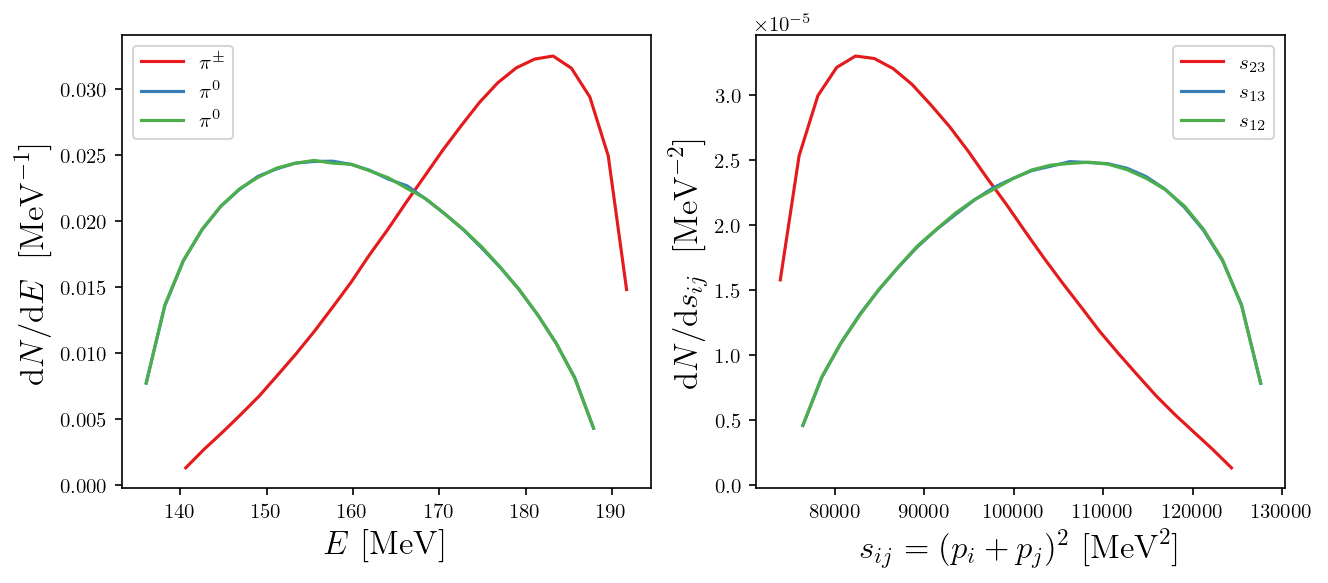

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(10,4))

labels = [r"$\pi^{\pm}$", r"$\pi^{0}$", r"$\pi^{0}$"]
for (cs, ps), label in zip(k_to_pi_pi0_pi0_edists, labels):
    axes[0].plot(cs, ps, label=label)

axes[0].legend()
axes[0].set_ylabel(r"$\dv*{N}{E} \ [\mathrm{MeV}^{-1}]$", fontdict={'size': 16})
axes[0].set_xlabel(r"$E \ [\mathrm{MeV}]$", fontdict={'size': 16})

labels = [r"$s_{23}$", r"$s_{13}$", r"$s_{12}$"]
dists = [k_to_pi_pi0_pi0_s_dist, k_to_pi_pi0_pi0_t_dist, k_to_pi_pi0_pi0_u_dist]
for (cs, ps), label in zip(dists, labels):
    axes[1].plot(cs, ps, label=label)

axes[1].set_ylabel(r"$\dv*{N}{s_{ij}} \ [\mathrm{MeV}^{-2}]$", fontdict={'size': 16})
axes[1].set_xlabel(r"$s_{ij} = (p_{i} + p_{j})^{2} \ [\mathrm{MeV}^{2}]$", fontdict={'size': 16})
axes[1].legend()

### $K^{\pm} \to \pi^{0} + \ell^{\pm} + \nu_{\ell}$

The squared matrix element was take from PDG ("Form Factors for Semileptonic Kaon, Radiative Pion and Kaon Decays"). They give the amplitude as
\begin{align*}
    \mathcal{A} = f_{+}(t)\left[(p_{k} + p_{\pi})_{\mu}\bar{\ell}\gamma_{\mu}(1+\gamma_{5})\bar{\nu}\right] 
    + f_{-}(t)\left[m_{\ell} \bar{\ell}(1+\gamma_{5})\nu\right]
\end{align*}
where $f_{\pm}$ is given by:
\begin{align*}
    f_{\pm}(t) = f_{\pm}(0)\left[1 + \lambda^{'}_{\pm} (t/m_{\pi}^{2}) + \lambda^{''}_{\pm} (t/m_{\pi}^{2})\right]
\end{align*}
I have no idea what the values of $f_{\pm}(0)$ are, but they state that 
\begin{align*}
    \lambda_{-} &\sim 0 & &\\
    \lambda'_{+,e} &= 2.59 \times 10^{-2}, &
    \lambda{''}_{+,e} &= 0.186 \times 10^{-2},\\
    \lambda'_{+,\mu} &= 24 \times 10^{-3}, &
    \lambda{''}_{+,\mu} &= 1.8 \times 10^{-3}
\end{align*}
We will just set $f_{\pm}(0) = 1$.

In [12]:
def msqrd_k_pi_l_nu(s, t, lep: str):
    if lep == "mu":
        fp0 = 1.0
        fm0 = 1.0
        lp1 = 24e-3 
        lp2 = 1.8e-3
        fp = lambda s: fp0 * (1.0 + lp1 * (s/MPI0**2) + 0.5 * lp2 * (s/MPI0**2)**2)
        fm = lambda s: fm0
        ml = MMU
    else:
        fp0 = 1.0
        fm0 = 1.0
        lp1 = 2.59e-2
        lp2 = 0.186e-2
        fp = lambda s: fp0 * (1.0 + lp1 * (s/MPI0**2) + 0.5 * lp2 * (s/MPI0**2)**2)
        fm = lambda s: 0.0
        ml = ME
    return -4 * (
        (ml ** 4 - ml ** 2 * s) * fm(s) ** 2
        + 2 * ml ** 2 * (ml ** 2 + 2 * MPI0 ** 2 - s - 2 * t) * fm(s) * fp(s)
        + (
            ml ** 4
            + 4 * MK ** 2 * (MPI0 ** 2 - t)
            + 4 * t * (-(MPI0 ** 2) + s + t)
            - ml ** 2 * (s + 4 * t)
        )
        * fp(s) ** 2
    )

In [13]:
msqrd_k_pi_e_nu = lambda s, t: msqrd_k_pi_l_nu(s, t, "e")
k_to_pi0_e_nu_ps = ThreeBodyPhaseSpace(MK, MPI0, ME, 0, msqrd_k_pi_e_nu)
k_to_pi0_e_nu_edists = k_to_pi0_e_nu_ps.energy_distributions(25,maxiter=1000)
k_to_pi0_e_nu_s_dist = k_to_pi0_e_nu_ps.invariant_mass_distribution(1, 2, 25, maxiter=1000)
k_to_pi0_e_nu_t_dist = k_to_pi0_e_nu_ps.invariant_mass_distribution(0, 2, 25, maxiter=1000)
k_to_pi0_e_nu_u_dist = k_to_pi0_e_nu_ps.invariant_mass_distribution(0, 1, 25, maxiter=1000)

msqrd_k_pi_mu_nu = lambda s, t: msqrd_k_pi_l_nu(s, t, "mu")
k_to_pi0_mu_nu_ps = ThreeBodyPhaseSpace(MK, MPI0, MMU, 0, msqrd_k_pi_mu_nu)
k_to_pi0_mu_nu_edists = k_to_pi0_mu_nu_ps.energy_distributions(25,maxiter=1000)
k_to_pi0_mu_nu_s_dist = k_to_pi0_mu_nu_ps.invariant_mass_distribution(1, 2, 25, maxiter=1000)
k_to_pi0_mu_nu_t_dist = k_to_pi0_mu_nu_ps.invariant_mass_distribution(0, 2, 25, maxiter=1000)
k_to_pi0_mu_nu_u_dist = k_to_pi0_mu_nu_ps.invariant_mass_distribution(0, 1, 25, maxiter=1000)

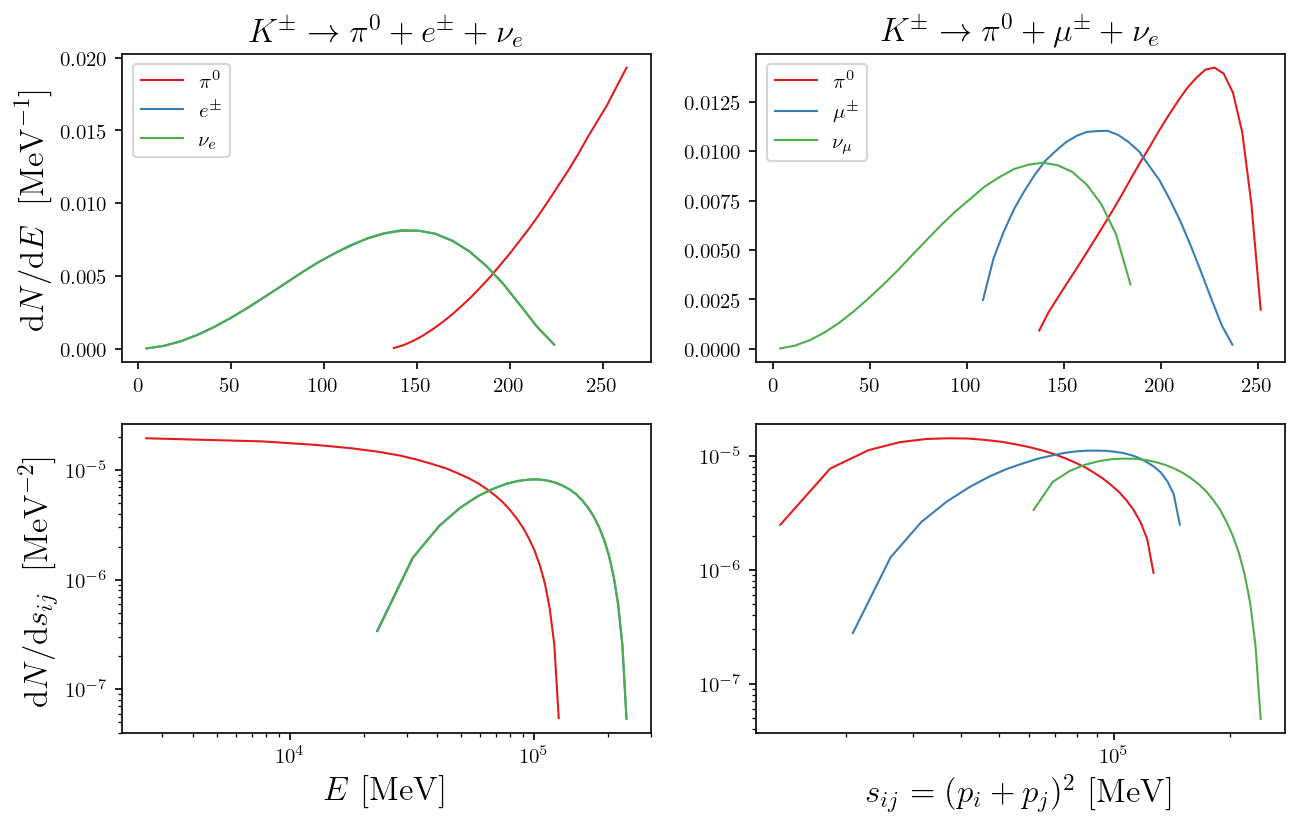

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6), dpi=150)

labels = [r"$\pi^{0}$", r"$e^{\pm}$", r"$\nu_{e}$"]
for (cs, ps), label in zip(k_to_pi0_e_nu_edists, labels):
    axes[0][0].plot(cs, ps, label=label, lw=1)

labels = [r"$\pi^{0}$", r"$\mu^{\pm}$", r"$\nu_{\mu}$"]
for (cs, ps), label in zip(k_to_pi0_mu_nu_edists, labels):
    axes[0][1].plot(cs, ps, label=label, lw=1)


labels = [r"$s_{23}$", r"$s_{13}$", r"$s_{12}$"]
dists = [k_to_pi0_e_nu_s_dist, k_to_pi0_e_nu_t_dist, k_to_pi0_e_nu_u_dist]
for (cs, ps), label in zip(dists, labels):
    axes[1][0].plot(cs, ps, label=label, lw=1)

labels = [r"$s_{23}$", r"$s_{13}$", r"$s_{12}$"]
dists = [k_to_pi0_mu_nu_s_dist, k_to_pi0_mu_nu_t_dist, k_to_pi0_mu_nu_u_dist]
for (cs, ps), label in zip(dists, labels):
    axes[1][1].plot(cs, ps, label=label, lw=1)

axes[0][0].set_title(r"$K^{\pm} \to \pi^{0} + e^{\pm} + \nu_{e}$", fontdict={"size":16})
axes[0][1].set_title(r"$K^{\pm} \to \pi^{0} + \mu^{\pm} + \nu_{e}$", fontdict={"size":16})

axes[0][0].set_ylabel(r"$\dv*{N}{E} \ [\mathrm{MeV}^{-1}]$", fontdict={"size":16})
axes[1][0].set_ylabel(r"$\dv*{N}{s_{ij}} \ [\mathrm{MeV}^{-2}]$", fontdict={"size":16})

axes[1][0].set_xlabel(r"$E \ [\mathrm{MeV}]$", fontdict={"size":16})
axes[1][1].set_xlabel(r"$s_{ij} = (p_{i} + p_{j})^{2} \ [\mathrm{MeV}]$", fontdict={"size":16})


axes[0][0].legend()
axes[0][1].legend()


axes[1][0].set_xscale("log")
axes[1][1].set_xscale("log")
axes[1][0].set_yscale("log")
axes[1][1].set_yscale("log")

# axes[1].set_ylabel(r"$\dv*{N}{s_{ij}} \ [\mathrm{MeV}^{-2}]$", fontdict={'size': 16})
# axes[1].set_xlabel(r"$s_{ij} = (p_{i} + p_{j})^{2} \ [\mathrm{MeV}^{2}]$", fontdict={'size': 16})
# axes[1].legend()

# ax1.legend()
# ax2.legend()

### Save Data

In [16]:
with h5py.File(Path(os.getcwd()).joinpath("data").joinpath("k_decay_data.hdf5"), "w") as f:
    # K -> pi + pi + pi
    root = f.create_group("/pi_pi_pi")
    grp = root.create_group("energy_distributions")
    d1, d2, d3 = k_to_pi_pi_pi_edists
    grp.create_dataset("energies", data=np.vstack((d1[0], d2[0], d3[0])))
    grp.create_dataset("probabilities", data=np.vstack((d1[1], d2[1], d3[1])))

    sdist = k_to_pi_pi_pi_s_dist
    tdist = k_to_pi_pi_pi_t_dist
    udist = k_to_pi_pi_pi_u_dist
    grp = root.create_group("invariant_mass_distributions/s")
    grp.create_dataset("invariant_masses", data=sdist[0])
    grp.create_dataset("probabilities", data=sdist[1])

    grp = root.create_group("invariant_mass_distributions/t")
    grp.create_dataset("invariant_masses", data=tdist[0])
    grp.create_dataset("probabilities", data=tdist[1])
    
    grp = root.create_group("invariant_mass_distributions/u")
    grp.create_dataset("invariant_masses", data=udist[0])
    grp.create_dataset("probabilities", data=udist[1])

    # K -> pi + pi0 + pi0
    root = f.create_group("/pi_pi0_pi0")
    grp = root.create_group("energy_distributions")
    d1, d2, d3 = k_to_pi_pi0_pi0_edists
    grp.create_dataset("energies", data=np.vstack((d1[0], d2[0], d3[0])))
    grp.create_dataset("probabilities", data=np.vstack((d1[1], d2[1], d3[1])))

    sdist = k_to_pi_pi0_pi0_s_dist
    tdist = k_to_pi_pi0_pi0_t_dist
    udist = k_to_pi_pi0_pi0_u_dist
    grp = root.create_group("invariant_mass_distributions/s")
    grp.create_dataset("invariant_masses", data=sdist[0])
    grp.create_dataset("probabilities", data=sdist[1])

    grp = root.create_group("invariant_mass_distributions/t")
    grp.create_dataset("invariant_masses", data=tdist[0])
    grp.create_dataset("probabilities", data=tdist[1])
    
    grp = root.create_group("invariant_mass_distributions/u")
    grp.create_dataset("invariant_masses", data=udist[0])
    grp.create_dataset("probabilities", data=udist[1])

    # K -> pi0 + e + nu
    root = f.create_group("/pi0_e_nu")
    grp = root.create_group("energy_distributions")
    d1, d2, d3 = k_to_pi0_e_nu_edists
    grp.create_dataset("energies", data=np.vstack((d1[0], d2[0], d3[0])))
    grp.create_dataset("probabilities", data=np.vstack((d1[1], d2[1], d3[1])))

    sdist = k_to_pi0_e_nu_s_dist
    tdist = k_to_pi0_e_nu_t_dist
    udist = k_to_pi0_e_nu_u_dist
    grp = root.create_group("invariant_mass_distributions/s")
    grp.create_dataset("invariant_masses", data=sdist[0])
    grp.create_dataset("probabilities", data=sdist[1])

    grp = root.create_group("invariant_mass_distributions/t")
    grp.create_dataset("invariant_masses", data=tdist[0])
    grp.create_dataset("probabilities", data=tdist[1])
    
    grp = root.create_group("invariant_mass_distributions/u")
    grp.create_dataset("invariant_masses", data=udist[0])
    grp.create_dataset("probabilities", data=udist[1])

    # K -> pi0 + mu + nu
    root = f.create_group("/pi0_mu_nu")
    grp = root.create_group("energy_distributions")
    d1, d2, d3 = k_to_pi0_mu_nu_edists
    grp.create_dataset("energies", data=np.vstack((d1[0], d2[0], d3[0])))
    grp.create_dataset("probabilities", data=np.vstack((d1[1], d2[1], d3[1])))

    sdist = k_to_pi0_mu_nu_s_dist
    tdist = k_to_pi0_mu_nu_t_dist
    udist = k_to_pi0_mu_nu_u_dist
    grp = root.create_group("invariant_mass_distributions/s")
    grp.create_dataset("invariant_masses", data=sdist[0])
    grp.create_dataset("probabilities", data=sdist[1])

    grp = root.create_group("invariant_mass_distributions/t")
    grp.create_dataset("invariant_masses", data=tdist[0])
    grp.create_dataset("probabilities", data=tdist[1])
    
    grp = root.create_group("invariant_mass_distributions/u")
    grp.create_dataset("invariant_masses", data=udist[0])
    grp.create_dataset("probabilities", data=udist[1])

## Photon Spectra

In [8]:
def kallen_lambda(a, b, c):
    return a**2 + b**2 + c**2 - 2 * a * b - 2 * a * c - 2 * b * c

def two_body_three_momentum(cme, m1, m2):
    return np.sqrt(kallen_lambda(cme**2, m1**2, m2**2)) / (2 * cme)

def energy_one_cme(cme, m1, m2):
    return (cme**2 + m1**2 - m2**2) / (2 * cme)

In [9]:
class ParticleType(Enum):
    Scalar = 0
    Fermion = 1
    Vector = 2


def _dndx_photon_fsr(x, s, m, q=1.0, ty: ParticleType = ParticleType.Fermion):
    pre = q ** 2 * alpha_em / (2.0 * np.pi)
    xm = 1.0 - x

    if ty == ParticleType.Scalar:
        kernel = np.where(np.e * m ** 2 / s > xm, 0.0,
            2.0 * xm / x * (np.log(s * xm / m ** 2) - 1.0)
        )
    elif ty == ParticleType.Fermion:
        kernel = np.where(np.e * m ** 2 / s > xm, 0.0,
            (1.0 + xm ** 2) / x * (np.log(s * xm / m ** 2) - 1.0)
        )
    else:
        y = s * xm ** 2 / (4.0 * m ** 2)
        lf1 = np.log(y) + 2.0 * np.log(1.0 - np.sqrt(1.0 - 1.0 / y))
        lf2 = np.log(s / m ** 2)
        kernel = 2.0 * (x / xm * lf1 + xm / x * lf2 + x * xm * lf2)

    return pre * kernel


def _dnde_photon_fsr(e, s, m, q=1.0, ty: ParticleType = ParticleType.Fermion):
    e_to_x = 2.0 / np.sqrt(s)
    x = e * e_to_x
    return _dndx_photon_fsr(x, s, m, q, ty) * e_to_x

def dndx_photon_fsr_fermion(x, s, m, q=1.0):
    return _dndx_photon_fsr(x, s, m, q=1.0, ty=ParticleType.Fermion)

def dndx_photon_fsr_scalar(x, s, m, q=1.0):
    return _dndx_photon_fsr(x, s, m, q=1.0, ty=ParticleType.Scalar)

def dndx_photon_fsr_vector(x, s, m, q=1.0):
    return _dndx_photon_fsr(x, s, m, q=1.0, ty=ParticleType.Vector)

def dnde_photon_fsr_fermion(e, s, m, q=1.0):
    return _dnde_photon_fsr(e, s, m, q=1.0, ty=ParticleType.Fermion)

def dnde_photon_fsr_scalar(e, s, m, q=1.0):
    return _dnde_photon_fsr(e, s, m, q=1.0, ty=ParticleType.Scalar)

def dnde_photon_fsr_vector(e, s, m, q=1.0):
    return _dnde_photon_fsr(e, s, m, q=1.0, ty=ParticleType.Vector)

def convolve(e, dnde, energies, probabilities):
    integrand = np.array([p * dnde(e, ep) for ep, p in zip(energies, probabilities)])
    return np.trapz(integrand, energies, axis=0)

In [10]:
class ChargedKaonSpectra:

    def __init__(self):
        file = Path(os.getcwd()).joinpath("data").joinpath("k_decay_data.hdf5")
        with h5py.File(file, "r") as f:
            self._edists = {
                "pi pi pi": {
                    "e": f["/pi_pi_pi/energy_distributions/energies"][:],
                    "dnde": f["/pi_pi_pi/energy_distributions/probabilities"][:],
                },
                "pi pi0 pi0": {
                    "e": f["/pi_pi0_pi0/energy_distributions/energies"][:],
                    "dnde": f["/pi_pi0_pi0/energy_distributions/probabilities"][:],
                },
                "pi0 e nu": {
                    "e": f["/pi0_e_nu/energy_distributions/energies"][:],
                    "dnde": f["/pi0_e_nu/energy_distributions/probabilities"][:],
                },
                "pi0 mu nu": {
                    "e": f["/pi0_mu_nu/energy_distributions/energies"][:],
                    "dnde": f["/pi0_mu_nu/energy_distributions/probabilities"][:],
                },
            }
            self._invariant_mass_dists = {
                "pi pi pi": {
                    "s": f["/pi_pi_pi/invariant_mass_distributions/s/invariant_masses"][:],
                    "t": f["/pi_pi_pi/invariant_mass_distributions/t/invariant_masses"][:],
                    "u": f["/pi_pi_pi/invariant_mass_distributions/u/invariant_masses"][:],
                    "dnds": f["/pi_pi_pi/invariant_mass_distributions/s/probabilities"][:],
                    "dndt": f["/pi_pi_pi/invariant_mass_distributions/t/probabilities"][:],
                    "dndu": f["/pi_pi_pi/invariant_mass_distributions/u/probabilities"][:],
                },
                "pi pi0 pi0": {
                    "s": f["/pi_pi0_pi0/invariant_mass_distributions/s/invariant_masses"][:],
                    "t": f["/pi_pi0_pi0/invariant_mass_distributions/t/invariant_masses"][:],
                    "u": f["/pi_pi0_pi0/invariant_mass_distributions/u/invariant_masses"][:],
                    "dnds": f["/pi_pi0_pi0/invariant_mass_distributions/s/probabilities"][:],
                    "dndt": f["/pi_pi0_pi0/invariant_mass_distributions/t/probabilities"][:],
                    "dndu": f["/pi_pi0_pi0/invariant_mass_distributions/u/probabilities"][:],
                },
                "pi0 e nu": {
                    "s": f["/pi0_e_nu/invariant_mass_distributions/s/invariant_masses"][:],
                    "t": f["/pi0_e_nu/invariant_mass_distributions/t/invariant_masses"][:],
                    "u": f["/pi0_e_nu/invariant_mass_distributions/u/invariant_masses"][:],
                    "dnds": f["/pi0_e_nu/invariant_mass_distributions/s/probabilities"][:],
                    "dndt": f["/pi0_e_nu/invariant_mass_distributions/t/probabilities"][:],
                    "dndu": f["/pi0_e_nu/invariant_mass_distributions/u/probabilities"][:],
                },
                "pi0 mu nu": {
                    "s": f["/pi0_mu_nu/invariant_mass_distributions/s/invariant_masses"][:],
                    "t": f["/pi0_mu_nu/invariant_mass_distributions/t/invariant_masses"][:],
                    "u": f["/pi0_mu_nu/invariant_mass_distributions/u/invariant_masses"][:],
                    "dnds": f["/pi0_mu_nu/invariant_mass_distributions/s/probabilities"][:],
                    "dndt": f["/pi0_mu_nu/invariant_mass_distributions/t/probabilities"][:],
                    "dndu": f["/pi0_mu_nu/invariant_mass_distributions/u/probabilities"][:],
                },
            }

    def dnde_photon_mu_nu(self, e, ty=None):
        br = BR_K_TO_MU_NUMU
        res = np.zeros_like(e)
        if ty is None or ty == "charged":
            emu = energy_one_cme(MK, MMU, 0)
            res += dnde_mu(e, emu)
            res += dnde_photon_fsr_fermion(e, MK**2, MMU, q=-1.0)

        return res

    def dnde_photon_pi_pi0(self, e, ty=None):
        br = BR_K_TO_PI_PI0
        res = np.zeros_like(e)
        if ty is None or ty == "charged":
            epi = energy_one_cme(MK, MPI, MPI0)
            res += dnde_cp(e, epi)
            res += dnde_photon_fsr_scalar(e, MK**2, MPI, q=1.0)
        if ty is None or ty == "neutral":
            epi0 = energy_one_cme(MK, MPI0, MPI)
            res += dnde_np(e, epi0)

        return res

    def dnde_photon_pi_pi_pi(self, e, ty=None):
        br = BR_K_TO_PI_PI_PI
        res = np.zeros_like(e)
        if ty is None or ty == "charged":
            dists = self._edists["pi pi pi"]
            res += convolve(e, dnde_cp, dists["e"][0], dists["dnde"][0])
            res += convolve(e, dnde_cp, dists["e"][1], dists["dnde"][1])
            res += convolve(e, dnde_cp, dists["e"][2], dists["dnde"][2])
        
            fsr = lambda x, y: dnde_photon_fsr_scalar(x, y, MPI, q=1.0)
            inv_dist = self._invariant_mass_dists["pi pi pi"]
            res += 0.5 * convolve(e, fsr, inv_dist["s"], inv_dist["dnds"])
            res += 0.5 * convolve(e, fsr, inv_dist["t"], inv_dist["dndt"])
            res += 0.5 * convolve(e, fsr, inv_dist["u"], inv_dist["dndu"])

        return res

    def dnde_photon_pi_pi0_pi0(self, e, ty=None):
        br = BR_K_TO_PI_PI0_PI0
        key = "pi pi0 pi0"
        res = np.zeros_like(e)

        dists = self._edists[key]
        inv_dist = self._invariant_mass_dists[key]
        if ty is None or ty == "charged":
            res += convolve(e, dnde_cp, dists["e"][0], dists["dnde"][0])
            # Average FSR over t and u channels 
            fsr = lambda x, y: dnde_photon_fsr_scalar(x, y, MPI, q=1.0)
            res += 0.5 * convolve(e, fsr, inv_dist["t"], inv_dist["dndt"])
            res += 0.5 * convolve(e, fsr, inv_dist["u"], inv_dist["dndu"])
        if ty is None or ty == "neutral":
            res += convolve(e, dnde_np, dists["e"][1], dists["dnde"][1])
            res += convolve(e, dnde_np, dists["e"][2], dists["dnde"][2])

        return res

    def dnde_photon_pi0_e_nu(self, e, ty=None):
        br = BR_K_TO_E_NUE_PI0
        key = "pi0 e nu"

        res = np.zeros_like(e)
        if ty is None or ty == "neutral":
            dists = self._edists[key]
            res += convolve(e, dnde_np, dists["e"][0], dists["dnde"][0])
        if ty is None or ty == "charged":
            # Average FSR over s and u channels 
            fsr = lambda x, y: dnde_photon_fsr_fermion(x, y, ME, q=-1.0)
            inv_dist = self._invariant_mass_dists[key]
            res += 0.5 * convolve(e, fsr, inv_dist["s"], inv_dist["dnds"])
            res += 0.5 * convolve(e, fsr, inv_dist["u"], inv_dist["dndu"])

        return res

    def dnde_photon_pi0_mu_nu(self, e, ty=None):
        br = BR_K_TO_MU_NUMU_PI0
        key = "pi0 mu nu"
        res = np.zeros_like(e)
        dists = self._edists[key]
        if ty is None or ty == "neutral":
            res += convolve(e, dnde_np, dists["e"][0], dists["dnde"][0])
        if ty is None or ty == "charged":
            res += convolve(e, dnde_mu, dists["e"][1], dists["dnde"][1])
            # Average FSR over s and u channels 
            fsr = lambda x, y: dnde_photon_fsr_fermion(x, y, MMU, q=-1.0)
            inv_dist = self._invariant_mass_dists[key]
            res += 0.5 * convolve(e, fsr, inv_dist["s"], inv_dist["dnds"])
            res += 0.5 * convolve(e, fsr, inv_dist["u"], inv_dist["dndu"])

        return res

    def dnde_photon_charged(self, e):
        ty = "charged"
        res = np.zeros_like(e)
        res += BR_K_TO_MU_NUMU * self.dnde_photon_mu_nu(e, ty)
        res += BR_K_TO_PI_PI0 * self.dnde_photon_pi_pi0(e, ty)
        res += BR_K_TO_PI_PI_PI * self.dnde_photon_pi_pi_pi(e, ty)
        res += BR_K_TO_PI_PI0_PI0 * self.dnde_photon_pi_pi0_pi0(e, ty)
        res += BR_K_TO_E_NUE_PI0 * self.dnde_photon_pi0_e_nu(e, ty)
        res += BR_K_TO_MU_NUMU_PI0 * self.dnde_photon_pi0_mu_nu(e, ty)
        return res

    def dnde_photon_neutral(self, e):
        ty = "neutral"
        res = np.zeros_like(e)
        res += BR_K_TO_MU_NUMU * self.dnde_photon_mu_nu(e, ty)
        res += BR_K_TO_PI_PI0 * self.dnde_photon_pi_pi0(e, ty)
        res += BR_K_TO_PI_PI_PI * self.dnde_photon_pi_pi_pi(e, ty)
        res += BR_K_TO_PI_PI0_PI0 * self.dnde_photon_pi_pi0_pi0(e, ty)
        res += BR_K_TO_E_NUE_PI0 * self.dnde_photon_pi0_e_nu(e, ty)
        res += BR_K_TO_MU_NUMU_PI0 * self.dnde_photon_pi0_mu_nu(e, ty)
        return res

    def dnde_photon(self, e, components=False):
        mu_nu = BR_K_TO_MU_NUMU * self.dnde_photon_mu_nu(e)
        pi_pi0 = BR_K_TO_PI_PI0 * self.dnde_photon_pi_pi0(e)
        pi_pi_pi = BR_K_TO_PI_PI_PI * self.dnde_photon_pi_pi_pi(e)
        pi_pi0_pi0 = BR_K_TO_PI_PI0_PI0 * self.dnde_photon_pi_pi0_pi0(e)
        pi0_e_nu = BR_K_TO_E_NUE_PI0 * self.dnde_photon_pi0_e_nu(e)
        pi0_mu_nu = BR_K_TO_MU_NUMU_PI0 * self.dnde_photon_pi0_mu_nu(e)

        if components:
            return {
                "mu nu": mu_nu,
                "pi pi0": pi_pi0,
                "pi pi pi": pi_pi_pi,
                "pi0 e nu": pi0_e_nu,
                "pi0 mu nu": pi0_mu_nu,
                "pi pi0 pi0": pi_pi0_pi0,
            }
        return mu_nu + pi_pi0 + pi_pi_pi + pi_pi0_pi0 + pi0_e_nu + pi0_mu_nu

/tmp/ipykernel_728981/1731418707.py:17: RuntimeWarning: invalid value encountered in log
  (1.0 + xm ** 2) / x * (np.log(s * xm / m ** 2) - 1.0)
/tmp/ipykernel_728981/1731418707.py:13: RuntimeWarning: invalid value encountered in log
  2.0 * xm / x * (np.log(s * xm / m ** 2) - 1.0)
/home/logan/github/Hazma/hazma/decay.py:208: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_charged_pion.charged_pion_decay_spectrum(


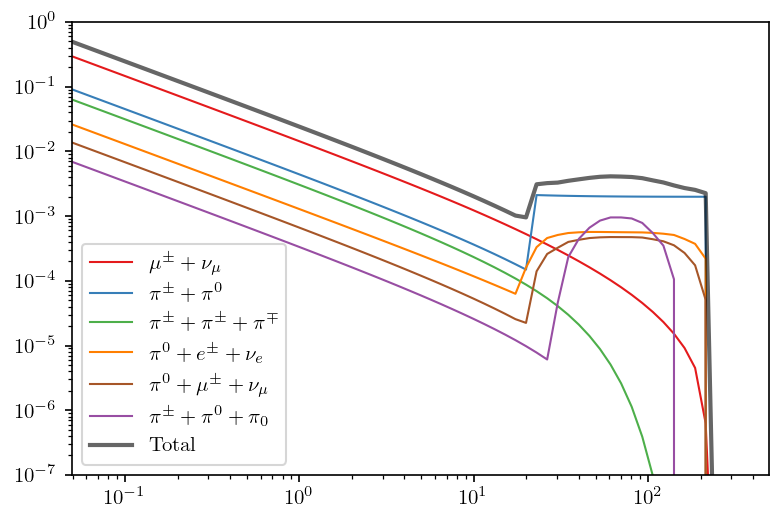

In [11]:
labels = {
    "mu nu" : r"$\mu^{\pm} + \nu_{\mu}$",
    "pi pi0" : r"$\pi^{\pm} + \pi^{0}$",
    "pi pi pi" : r"$\pi^{\pm} + \pi^{\pm} + \pi^{\mp}$",
    "pi pi0 pi0" : r"$\pi^{\pm} + \pi^{0} + \pi_{0}$",
    "pi0 e nu" : r"$\pi^{0} + e^{\pm} + \nu_{e}$",
    "pi0 mu nu" : r"$\pi^{0} + \mu^{\pm} + \nu_{\mu}$",
    "total": r"$\mathrm{Total}$"
}

plot_params = {
    "mu nu" : {"c": qualitative[0], "lw": 1},
    "pi pi0" : {"c": qualitative[1], "lw": 1},
    "pi pi pi" : {"c": qualitative[2], "lw": 1},
    "pi pi0 pi0" : {"c": qualitative[3], "lw": 1},
    "pi0 e nu" : {"c": qualitative[4], "lw": 1},
    "pi0 mu nu" :{"c": qualitative[5], "lw": 1},
    "total": {"c": "k", "lw": 2, "alpha": 0.6},
}

es = MK * np.geomspace(1e-6, 1.0, 100)
dnde_ck = ChargedKaonSpectra().dnde_photon(es, components=True)

plt.figure(dpi=150)

for key, val in dnde_ck.items():
    plt.plot(es, val, label=labels[key], **plot_params[key])
plt.plot(es, sum(dnde_ck.values()), label=labels["total"], **plot_params["total"])



plt.ylim(1e-7, 1e0)
plt.xlim(np.max(es) * 1e-4, np.max(es))
plt.yscale("log")
plt.xscale("log")
plt.legend()

/tmp/ipykernel_728981/1731418707.py:17: RuntimeWarning: invalid value encountered in log
  (1.0 + xm ** 2) / x * (np.log(s * xm / m ** 2) - 1.0)
/tmp/ipykernel_728981/1731418707.py:13: RuntimeWarning: invalid value encountered in log
  2.0 * xm / x * (np.log(s * xm / m ** 2) - 1.0)
/home/logan/github/Hazma/hazma/decay.py:208: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_charged_pion.charged_pion_decay_spectrum(


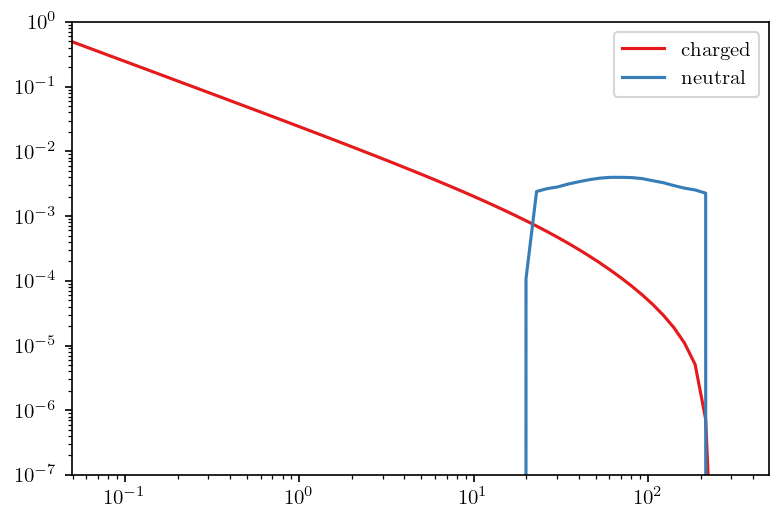

In [13]:
es = MK * np.geomspace(1e-6, 1.0, 100)
dnde_charged = ChargedKaonSpectra().dnde_photon_charged(es)
dnde_neutral = ChargedKaonSpectra().dnde_photon_neutral(es)

plt.figure(dpi=150)

plt.plot(es, dnde_charged, label="charged")
plt.plot(es, dnde_neutral, label="neutral")


plt.ylim(1e-7, 1e0)
plt.xlim(np.max(es) * 1e-4, np.max(es))
plt.yscale("log")
plt.xscale("log")
plt.legend()

In [26]:
es = MK * np.geomspace(1e-6, 1.0, 500)
dnde_ck = sum(ChargedKaonSpectra().dnde_photon(es, components=True).values())

s = slice(0, np.argwhere(dnde_ck <= 0)[0,0])
data = np.array([es[s], dnde_ck[s]]).T

np.savetxt(Path(os.getcwd()).joinpath("data").joinpath("k_dnde_photon.csv"), data, delimiter=",", header="energy, dnde")

/tmp/ipykernel_728981/1731418707.py:17: RuntimeWarning: invalid value encountered in log
  (1.0 + xm ** 2) / x * (np.log(s * xm / m ** 2) - 1.0)
/tmp/ipykernel_728981/1731418707.py:13: RuntimeWarning: invalid value encountered in log
  2.0 * xm / x * (np.log(s * xm / m ** 2) - 1.0)
